# Plot Dice Means from CV Sweep

## Setup

In [1]:
# imports
import csv
from collections import defaultdict
from dataclasses import dataclass
import numpy as np
from pathlib import Path
import re

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


## Classes and functions

In [2]:
@dataclass
class CVPoint:
    subtype: str # subtype name
    train_count: int # complete train pool size passed from tag
    mean_dice: float # mean dice score
    fold_id: int # fold id
    tag: str
    csv_path: Path # path to csv file with metrics


In [3]:
@dataclass
class PlotConfig:
    ROOT: str = '/ministorage/adina/selma_segmentation_preds/preds'
    SUBTYPES: list = None # ['ALL'] or specific list
    EXCLUDE_SUBTYPES: list = None # ['cv_folds']
    OUTPUT_DIR: str = None # directory to save plots, if None will only show
    ASCENDING: bool = False # sort x-axis lowest to highest if True
    SAVE_SUMMARY_CSV: bool = False # save summary csv with all points
    PLOT_COMBINED: bool = True # plot combined curve for all subtypes in one plot

    # color controls
    POINT_COLOR: str = 'deepskyblue' # point color, None for default
    LINE_COLOR: str = 'dimgray' # line color, None for default
    COMBINED_POINT_COLOR: str = None # point color for combined plot, None for default
    POINT_ALPHA: float = 0.7 # point alpha
    LINE_ALPHA: float = 0.9 # line alpha
    PRETRAIN_LABEL: str = 'Pretrained' # label for pretrained in legend
    PRETRAIN_MARKER: str = 'o' # marker for pretrained points

    # random init overlay controls
    INCLUDE_RAND: bool = False # include random init baseline
    RAND_ROOT: str = None # root directory for random init results
    RAND_POINT_COLOR: str = 'violet' # point color for random init, None for default
    RAND_MARKER: str = 'x' # marker for random init points
    RAND_POINT_ALPHA: float = 0.7 # alpha for random init points
    RAND_LABEL: str = 'Random init' # label for random init in legend

    # random init best fit line
    RAND_FIT_LINE: bool = True # include best fit line for random init points
    RAND_LINE_COLOR: str = None # line color for random init best fit line, None for default (defaults to RAND_POINT_COLOR)
    RAND_LINESTYLE: str = '--' # linestyle for random init best fit line
    RAND_LINE_ALPHA: float = 0.7 # alpha for random init best fit line
    RAND_LINE_LABEL: str = 'Random init best fit' # label for random init best fit line in legend

    def __post_init__(self):
        if self.SUBTYPES is None:
            self.SUBTYPES = ['ALL']
        if self.EXCLUDE_SUBTYPES is None:
            self.EXCLUDE_SUBTYPES = []


In [4]:
# function to find subtypes 
def find_subtypes(root, requested, exclude=None):
    
    # if all requested, find all subtypes
    if any(s.upper() == 'ALL' for s in requested):
        subtypes = sorted([d.name for d in root.iterdir() if d.is_dir()])

        # exclude if needed
        if exclude:
            subtypes = [s for s in subtypes if s not in set(exclude)]

        return subtypes

    # otherwise, return requested subtypes
    return requested


In [5]:
# function to parse counts from filename
def parse_counts_from_filename(tag):

    # regex for parsing tag names
    RE_CVFOLD = re.compile(r'cvfold(\d+)') # ex: cvfold0
    RE_FOLD = re.compile(r'_fold(\d+)') # ex: _fold0
    RE_FTTR = re.compile(r'_fttr(\d+)') # ex: _fttr10
    RE_NTR = re.compile(r'_ntr(\d+)') # ex: _ntr10 (preferred for train size)
    RE_TRLIM = re.compile(r'_trlim(\d+|ALL)') # ex: _trlim10 or _trlimALL

    # search fold id
    match = RE_CVFOLD.search(tag)
    if match:
        fold_id = int(match.group(1))
    else:
        match = RE_FOLD.search(tag)
        fold_id = int(match.group(1)) if match else -1

    # search complete train pool size (prefer _ntr if available)
    k = None
    match = RE_NTR.search(tag)
    if match:
        k = int(match.group(1))
    else:
        match = RE_FTTR.search(tag)
        if match:
            k = int(match.group(1))
        else:
            match = RE_TRLIM.search(tag)
            if match:
                val = match.group(1)
                if val != 'ALL':
                    try:
                        k = int(val)
                    except Exception:
                        k = None
    
    return fold_id, k


In [6]:
# function to read mean dice from CSV
def read_mean_dice_from_csv(csv_path):

    try:
        # open file
        with open(csv_path, 'r', newline='') as f:

            # read mean dice from file
            reader = csv.DictReader(f)
            for row in reader:
                if row.get('filename', '').strip().lower() == 'mean':
                    try:
                        return float(row['dice_050'])
                    except Exception:
                        return None

    except FileNotFoundError:
        return None
    
    return None


In [7]:
# scan subtypes preds for metrics csv and build list
def collect_subtype_points(subtype, root):

    # list to hold points
    points = []

    # subdir
    subdir = root / subtype
    if not subdir.exists():
        print(f'[WARN] Missing subtype directory: {subdir}')
        return points
    
    # tags
    tag_dirs = sorted([d for d in subdir.iterdir() if d.is_dir()])
    if not tag_dirs:
        print(f'[WARN] No tag directories found in {subdir}')
        return points
    
    found_csv = 0
    
    # iterate over tag dirs
    for tag_dir in tag_dirs:
        tag = tag_dir.name
        preds_dir = tag_dir / 'preds'
        search_dirs = [preds_dir] if preds_dir.exists() else [tag_dir]
        
        for base in search_dirs:
            for csv_path in base.glob('metrics_test_*.csv'):
                found_csv += 1
                fold_id, train_k = parse_counts_from_filename(tag)
                if train_k is None:
                    print(f'[WARN] Could not parse ntr (complete train pool) from tag "{tag}" in {csv_path}, skipping.')
                    continue

                # read mean dice
                mean_dice = read_mean_dice_from_csv(csv_path)
                if mean_dice is None or np.isnan(mean_dice):
                    print(f'[WARN] Mean dice not found or NaN in {csv_path}, skipping.')
                    continue

                # create CVPoint and add to list
                points.append(CVPoint(
                    subtype=subtype, 
                    train_count=train_k, 
                    mean_dice=float(mean_dice), 
                    fold_id=fold_id, 
                    tag=tag, 
                    csv_path=csv_path))
        
    print(f'[INFO] {subtype}: Scanned {len(tag_dirs)} tags, found {found_csv} CSV files, collected {len(points)} points.')
            
    # return list of points
    return points


## Plotting

In [8]:
# function to plot curve
def plot_subtype_curve(subtype, 
                       points, 
                       outdir=None, 
                       ascending=False, 
                       point_color=None, 
                       line_color=None, 
                       point_alpha=0.7, 
                       line_alpha=0.9,
                       overlay_points=None,
                       overlay_label='Random init',
                       overlay_color=None,
                       overlay_marker='x',
                       overlay_alpha=0.7,
                       overlay_fit=False,
                       overlay_line_color=None,
                       overlay_linestyle='--',
                       overlay_line_alpha=0.7,
                       overlay_line_label='Random init best fit'
                       ):

    # return if no points
    if not points:
        print(f'[WARN] No points to plot for {subtype}. Skipping.')
        return None
    
    # group points by fold id
    by_fold = defaultdict(list)
    for p in points:
        by_fold[p.fold_id].append(p)

    # define markers
    # marker_cycle = ['o', 's', '^', 'D', 'v', 'P', 'X', '*', '<', '>', 'H', 'h']
    fold_ids = sorted(by_fold.keys())

    # create plot
    plt.figure(figsize=(8, 6))
    first_pretrained = True

    # legend handles to control ordering
    pre_points_handle = None
    pre_line_handle = None
    rand_points_handle = None
    rand_line_handle = None

    # plot points for each fold
    for idx, fid in enumerate(fold_ids):
        pts = sorted(by_fold[fid], key=lambda r: r.train_count, reverse=not ascending)
        xs = [r.train_count for r in pts]
        ys = [r.mean_dice for r in pts]
        marker = 'o'
        this_label = 'Pretrained' if first_pretrained else '_nolegend_'
        h_points = plt.scatter(xs, ys, marker=marker, label=this_label, color=point_color, alpha=point_alpha, zorder=3)
        
        # only plot label for first fold (so it doesn't repeat in legend)
        if first_pretrained:
            pre_points_handle = h_points
        first_pretrained = False

    # overlay points if provided
    overlay_xs, overlay_ys = [], []
    if overlay_points:
        overlay_sorted = sorted(overlay_points, key=lambda r: r.train_count, reverse=not ascending)
        overlay_xs = [r.train_count for r in overlay_sorted]
        overlay_ys = [r.mean_dice for r in overlay_sorted]

        # draw random init points
        rand_points_handle = plt.scatter(overlay_xs, 
                                           overlay_ys, 
                                           marker=overlay_marker, 
                                           label=overlay_label, 
                                           color=overlay_color, 
                                           alpha=overlay_alpha,
                                           zorder=3
                                           )
        
        # add best fit line for overlay points if needed
        if overlay_fit and len(overlay_xs) >= 2:
            overlay_x_min, overlay_x_max = min(overlay_xs), max(overlay_xs)
            overlay_xfit = np.linspace(overlay_x_min, overlay_x_max, 100)
            overlay_coeffs = np.polyfit(overlay_xs, overlay_ys, deg=1) # linear fit
            overlay_yfit = np.polyval(overlay_coeffs, overlay_xfit)
            rand_line_handle = plt.plot(overlay_xfit, overlay_yfit,
                                          linestyle=overlay_linestyle,
                                          color=(overlay_line_color or overlay_color),
                                          alpha=overlay_line_alpha,
                                          label=overlay_line_label,
                                          zorder=2
                                          )[0]

    # add line of best fit
    xs_all = [r.train_count for r in points]
    ys_all = [r.mean_dice for r in points]
    if len(xs_all) >= 2:
        x_min, x_max = min(xs_all), max(xs_all)
        xfit = np.linspace(x_min, x_max, 100)
        coeffs = np.polyfit(xs_all, ys_all, deg=1) # linear fit
        yfit = np.polyval(coeffs, xfit)
        h_line = plt.plot(xfit, yfit, linestyle='-', color=line_color, alpha=line_alpha, label='Pretrained best fit', zorder=2)[0]
        pre_line_handle = h_line

    # x ticks
    ax = plt.gca()
    all_xs_for_xticks = xs_all + overlay_xs
    if all_xs_for_xticks:
        ax.set_xticks(range(min(all_xs_for_xticks), max(all_xs_for_xticks)+1, 1))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1)) # ensure ticks at every integer
    if not ascending:
        ax.invert_xaxis()


    # label
    plt.xlabel('Train pool size (ntr, total available train images before train/val finetune split)')
    plt.ylabel('Mean dice @0.5 (test set)')
    plt.title(f'{subtype}: CV performance vs. ntr count')
    plt.grid(True, linestyle='--', alpha=0.5)

    # legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(loc='best')
    lengend_ordered = [pre_points_handle, pre_line_handle, rand_points_handle, rand_line_handle]
    lengend_ordered = [h for h in lengend_ordered if h is not None]
    if lengend_ordered:
        plt.legend(handles=lengend_ordered, labels=[h.get_label() for h in lengend_ordered], loc='best')
    
    # if overlay_points:
    #     handles.insert(0, Line2D([0], [0], linestyle='', marker=overlay_marker, color=overlay_color, label=overlay_label))
    # if line_color is not None:
    #     pass # line already has label from plt.plot
    # if handles:
    #     plt.legend(handles=handles, loc='best')

    plt.tight_layout()

    # save plot
    if outdir is not None:
        outdir.mkdir(parents=True, exist_ok=True)
        outpath = outdir / f'{subtype}_cv_dice_vs_train.png'
        plt.savefig(outpath)
        plt.close()
        return outpath

    # show plot
    plt.show()




In [9]:
# function to plot all subtypes
def plot_all_subtypes(
        subtype_to_points, 
        outdir=None, 
        ascending=False, 
        scatter_color=None, 
        point_alpha=0.7,
        overlay=None,
        overlay_color='orange',
        overlay_marker='x',
        overlay_alpha=0.7,
        overlay_label='Random init',
        overlay_fit=False,
        overlay_line_color=None,
        overlay_linestyle='--',
        overlay_line_alpha=0.7,
        overlay_line_label='Random init best fit'
    ):

    # filter to subtypes with at least 1 point
    filtered = {k: v for k, v in subtype_to_points.items() if v}
    if not filtered:
        print('[WARN] No subtypes with points to plot. Skipping combined plot.')
        return None
    
    # create plot
    plt.figure(figsize=(10, 6))

    # sort within each subtype by train_count
    for subtype, points in sorted(filtered.items()):
        points_sorted = sorted(points, key=lambda r: r.train_count, reverse=not ascending)
        xs = [r.train_count for r in points_sorted]
        ys = [r.mean_dice for r in points_sorted]
        plt.scatter(xs, ys, marker='o', label=subtype, color=scatter_color, alpha=point_alpha)

    # overlay random init points
    overlay_xs_all, overlay_ys_all = [], []
    if overlay:
        first_overlay = True
        for subtype, points in overlay.items():
            if not points:
                continue
            points_sorted = sorted(points, key=lambda r: r.train_count, reverse=not ascending)
            xs = [r.train_count for r in points_sorted]
            ys = [r.mean_dice for r in points_sorted]
            overlay_xs_all.extend(xs)
            overlay_ys_all.extend(ys)
            lbl = overlay_label if first_overlay else '_nolegend_'
            plt.scatter(xs, ys, marker=overlay_marker, label=lbl, color=overlay_color, alpha=overlay_alpha)
            first_overlay = False

    # add best fit line for overlay points if needed
    if overlay and overlay_fit and len(overlay_xs_all) >= 2:
        overlay_x_min, overlay_x_max = min(overlay_xs_all), max(overlay_xs_all)
        overlay_xfit = np.linspace(overlay_x_min, overlay_x_max, 100)
        overlay_coeffs = np.polyfit(overlay_xs_all, overlay_ys_all, deg=1) # linear fit
        overlay_yfit = np.polyval(overlay_coeffs, overlay_xfit)
        plt.plot(overlay_xfit, overlay_yfit,
                 linestyle=overlay_linestyle,
                 color=(overlay_line_color or overlay_color),
                 alpha=overlay_line_alpha,
                 label=overlay_line_label
                )

    # x ticks
    ax = plt.gca()
    all_xs = [p.train_count for points in filtered.values() for p in points]
    if overlay_xs_all:
        all_xs = all_xs + overlay_xs_all
    if all_xs:
        ax.set_xticks(range(min(all_xs), max(all_xs)+1, 1))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    if not ascending:
        ax.invert_xaxis()

    # label
    plt.xlabel('Train pool size (ntr, total available train images before train/val finetune split)')
    plt.ylabel('Mean dice @0.5 (test set)')
    plt.title('All subtypes: Dice vs. ntr count (train pool size)')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # legend
    plt.legend(loc='best')
    # handles, labels = plt.gca().get_legend_handles_labels()
    # if overlay:
    #     handles.append(Line2D([0], [0], linestyle='', marker=overlay_marker, color=overlay_color, label=overlay_label))
    #     labels.append(overlay_label)
    # if handles:
    #     plt.legend(handles=handles, labels=labels, loc='best')

    plt.tight_layout()

    # show plot    
    plt.show()

    # save plot
    if outdir is not None:
        outdir.mkdir(parents=True, exist_ok=True)
        outpath = outdir / 'all_subtypes_dice_vs_train_size.png'
        plt.savefig(outpath)
        plt.close()
        return outpath


In [10]:
# main
def main(config):

    # resolve paths
    root = Path(config.ROOT)
    outdir = Path(config.OUTPUT_DIR) if config.OUTPUT_DIR else None

    # find subtypes
    subtypes = find_subtypes(root, config.SUBTYPES, config.EXCLUDE_SUBTYPES)
    print(f'[INFO] Found subtypes: {subtypes}')

    # optionally gather summary csv across all subtypes
    summary_rows = []

    # keep mapping for combined plot
    subtype_to_points = {}
    subtype_to_points_rand = {}

    # dict for plots
    plots = {}

    # process each subtype
    for subtype in subtypes:

        # collect points (train_count, mean_dice, eval_count)
        points = collect_subtype_points(subtype, root)
        if not points:
            print(f'[WARN] No metrics with MEAN found for {subtype}.')
            plots[subtype] = None
            continue

        # optionally include random init points
        rand_points = []
        if getattr(config, 'INCLUDE_RAND', False) and getattr(config, 'RAND_ROOT', None):
            rand_root = Path(config.RAND_ROOT)
            if rand_root.exists():
                rand_points = collect_subtype_points(subtype, rand_root)
            else:
                print(f'[WARN] RAND_ROOT {rand_root} does not exist. Skipping random init points.')
        if rand_points:
            subtype_to_points_rand[subtype] = rand_points

        # save for combined plot if needed
        subtype_to_points[subtype] = points

        # accumulate rows for the combined summary csv
        for r in points:
            summary_rows.append({
                'subtype': subtype,
                'train_count': str(r.train_count),
                'fold_id': r.fold_id,
                'mean_dice_050': f'{r.mean_dice:.6f}',
                'metrics_csv': str(r.csv_path),
                'tag': r.tag
            })

        # save plot path
        plots[subtype] = plot_subtype_curve(
            subtype=subtype, 
            points=points, 
            outdir=outdir, 
            ascending=config.ASCENDING,
            point_color=config.POINT_COLOR,
            line_color=config.LINE_COLOR,
            point_alpha=config.POINT_ALPHA,
            line_alpha=config.LINE_ALPHA,
            overlay_points=rand_points if rand_points else None,
            overlay_label=getattr(config, 'RAND_LABEL', 'Random Init'),
            overlay_color=getattr(config, 'RAND_POINT_COLOR', 'violet'),
            overlay_marker=getattr(config, 'RAND_MARKER', 'x'),
            overlay_alpha=getattr(config, 'RAND_POINT_ALPHA', 0.7),
            overlay_fit=getattr(config, 'RAND_FIT_LINE', True),
            overlay_line_color=getattr(config, 'RAND_LINE_COLOR', None),
            overlay_linestyle=getattr(config, 'RAND_LINESTYLE', '--'),
            overlay_line_alpha=getattr(config, 'RAND_LINE_ALPHA', 0.7),
            overlay_line_label=getattr(config, 'RAND_LINE_LABEL', 'Random init best fit')
        )

    # combined plot if requested
    combined_plot = None
    if config.PLOT_COMBINED and subtype_to_points:
        combined_plot = plot_all_subtypes(
            subtype_to_points, 
            outdir=outdir, 
            ascending=config.ASCENDING,
            scatter_color=config.COMBINED_POINT_COLOR,
            point_alpha=config.POINT_ALPHA,
            overlay=subtype_to_points_rand if subtype_to_points_rand else None,
            overlay_color=getattr(config, 'RAND_POINT_COLOR', 'violet'),
            overlay_marker=getattr(config, 'RAND_MARKER', 'x'),
            overlay_alpha=getattr(config, 'RAND_POINT_ALPHA', 0.7),
            overlay_label=getattr(config, 'RAND_LABEL', 'Random Init'),
            overlay_fit=getattr(config, 'RAND_FIT_LINE', True),
            overlay_line_color=getattr(config, 'RAND_LINE_COLOR', None),
            overlay_linestyle=getattr(config, 'RAND_LINESTYLE', '--'),
            overlay_line_alpha=getattr(config, 'RAND_LINE_ALPHA', 0.7),
            overlay_line_label=getattr(config, 'RAND_LINE_LABEL', 'Random init best fit')
        )

    # save combined summary csv if requested
    summary_csv_path = None
    if config.SAVE_SUMMARY_CSV and summary_rows and outdir is not None:
        outdir.mkdir(parents=True, exist_ok=True)
        summary_csv = outdir / 'dice_vs_traincount_summary.csv'
        with open(summary_csv, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=['subtype', 'train_count', 'fold_id', 'mean_dice_050', 'metrics_csv', 'tag'])
            writer.writeheader()
            writer.writerows(summary_rows)
        print(f'[INFO] Saved summary CSV to {summary_csv}')
        summary_csv_path = str(summary_csv)

    return {
        'subtypes': subtypes,
        'plots': plots,
        'combined_plot': combined_plot,
        'summary_csv': summary_csv_path,
        'summary_rows': summary_rows,
    }


[INFO] Found subtypes: ['amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'vessels']
[INFO] amyloid_plaque: Scanned 48 tags, found 48 CSV files, collected 48 points.
[INFO] amyloid_plaque: Scanned 48 tags, found 48 CSV files, collected 48 points.


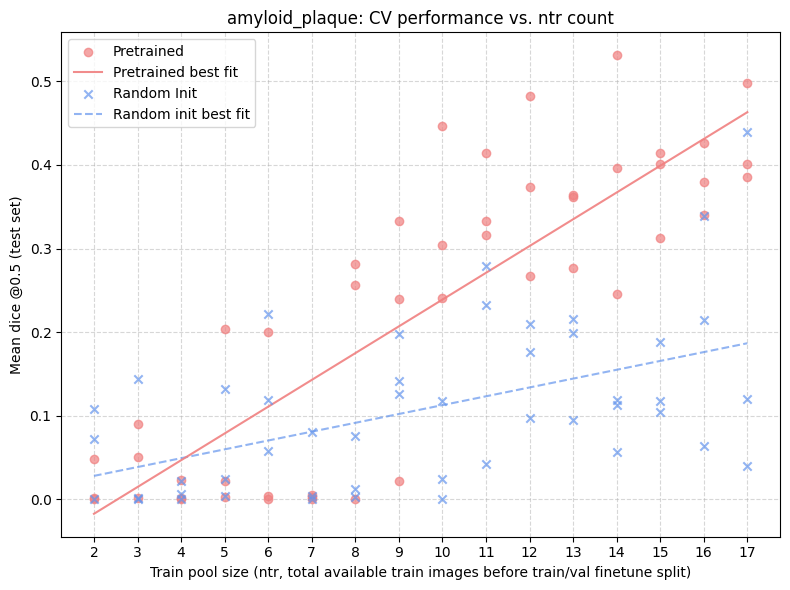

[INFO] c_fos_positive: Scanned 3 tags, found 3 CSV files, collected 3 points.
[INFO] c_fos_positive: Scanned 3 tags, found 3 CSV files, collected 3 points.


/tmp/ipykernel_2108169/3381485764.py:81: RankWarning: Polyfit may be poorly conditioned
  overlay_coeffs = np.polyfit(overlay_xs, overlay_ys, deg=1) # linear fit
/tmp/ipykernel_2108169/3381485764.py:97: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(xs_all, ys_all, deg=1) # linear fit


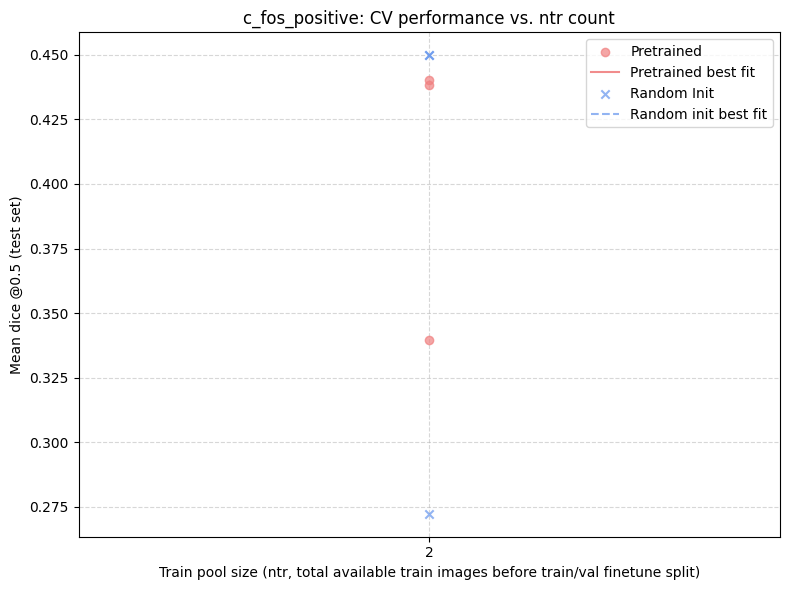

[INFO] cell_nucleus: Scanned 66 tags, found 66 CSV files, collected 66 points.
[INFO] cell_nucleus: Scanned 66 tags, found 66 CSV files, collected 66 points.


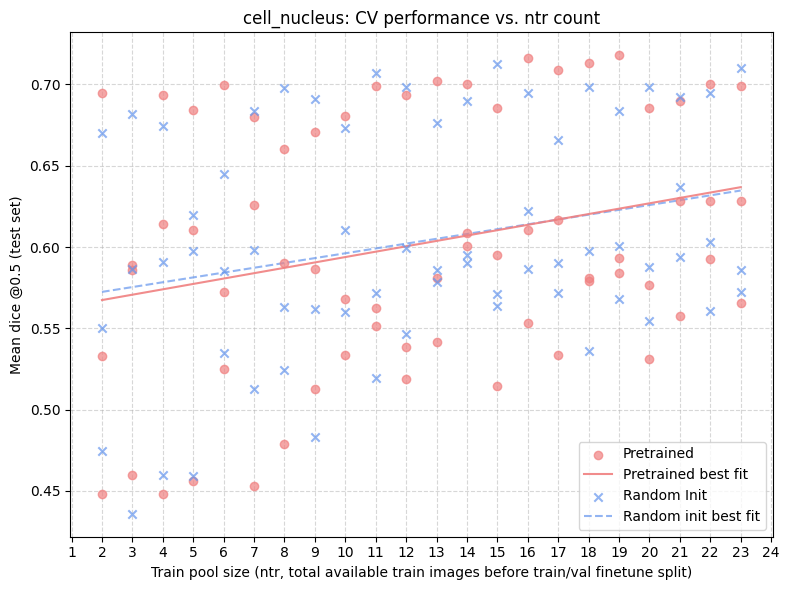

[INFO] vessels: Scanned 57 tags, found 57 CSV files, collected 57 points.
[INFO] vessels: Scanned 57 tags, found 57 CSV files, collected 57 points.


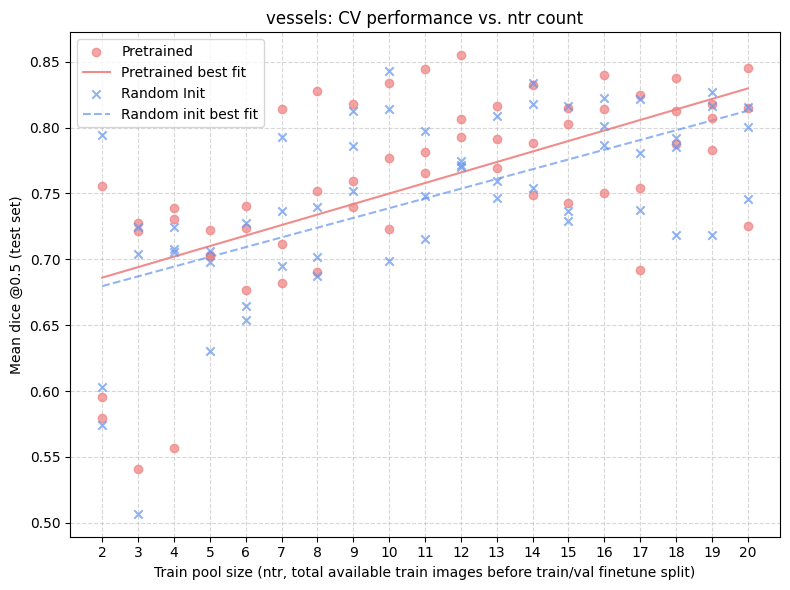

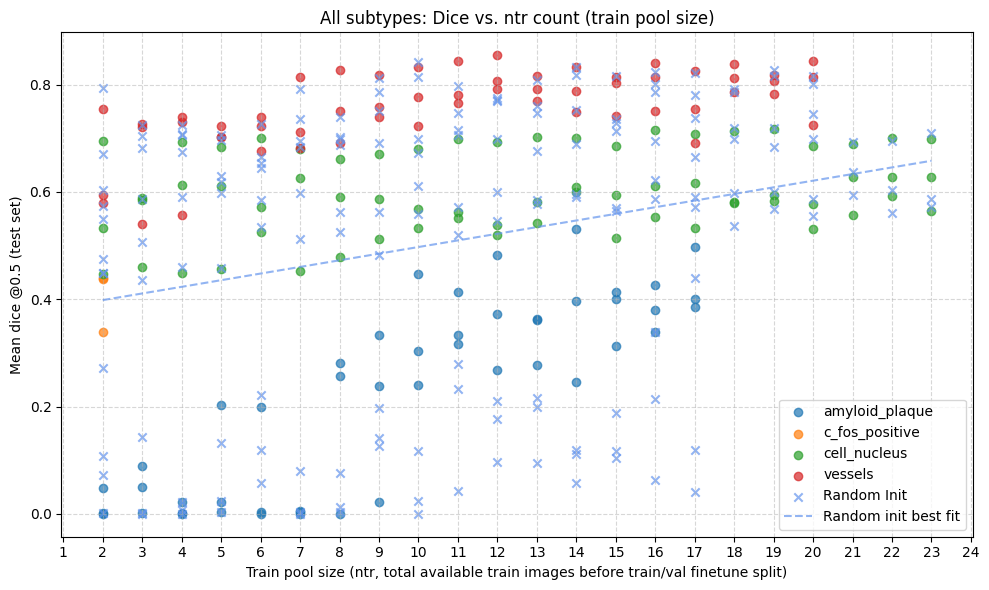

[INFO] Artifacts: {'subtypes': ['amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'vessels'], 'plots': {'amyloid_plaque': None, 'c_fos_positive': None, 'cell_nucleus': None, 'vessels': None}, 'combined_plot': None, 'summary_csv': None, 'summary_rows': [{'subtype': 'amyloid_plaque', 'train_count': '10', 'fold_id': 0, 'mean_dice_050': '0.241084', 'metrics_csv': '/ministorage/adina/selma_segmentation_preds_expert_sweep_31/preds/amyloid_plaque/cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_seed100/preds/metrics_test_cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_seed100.csv', 'tag': 'cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_seed100'}, {'subtype': 'amyloid_plaque', 'train_count': '11', 'fold_id': 0, 'mean_dice_050': '0.333456', 'metrics_csv': '/ministorage/adina/selma_segmentation_preds_expert_sweep_31/preds/amyloid_plaque/cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_seed100/preds/metrics_test_cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_seed100.csv', 'tag': 'cvfold0_ntr11_nev2_fttr9

In [11]:
# main entry
if __name__ == '__main__':
    cfg = PlotConfig(
        ROOT='/ministorage/adina/selma_segmentation_preds_expert_sweep_31/preds',
        SUBTYPES=['ALL'],
        EXCLUDE_SUBTYPES=['cv_folds'],
        OUTPUT_DIR=None,
        ASCENDING=True,
        SAVE_SUMMARY_CSV=False,
        PLOT_COMBINED=True,
        POINT_COLOR='lightcoral',
        LINE_COLOR='lightcoral',

        # enable random init overlay
        INCLUDE_RAND=True,
        RAND_ROOT='/ministorage/adina/selma_segmentation_preds_rand/preds',
        RAND_POINT_COLOR='cornflowerblue',
        RAND_MARKER='x',
        RAND_POINT_ALPHA=0.7,
        RAND_LABEL='Random Init',

        # best fit line for random init
        RAND_FIT_LINE=True,
        RAND_LINESTYLE='--',
        RAND_LINE_ALPHA=0.7,
        RAND_LINE_COLOR=None, # defaults to RAND_POINT_COLOR if None
        RAND_LINE_LABEL='Random init best fit'
    )
    artifacts = main(cfg)
    print(f'[INFO] Artifacts: {artifacts}')


[INFO] Found subtypes: ['amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'vessels']
[INFO] amyloid_plaque: Scanned 48 tags, found 48 CSV files, collected 48 points.
[INFO] amyloid_plaque: Scanned 48 tags, found 48 CSV files, collected 48 points.


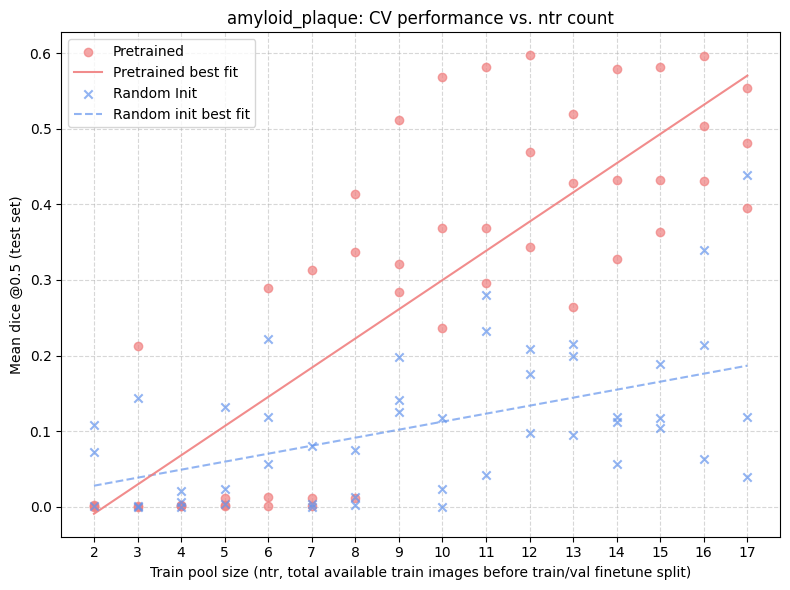

[INFO] c_fos_positive: Scanned 3 tags, found 3 CSV files, collected 3 points.
[INFO] c_fos_positive: Scanned 3 tags, found 3 CSV files, collected 3 points.


/tmp/ipykernel_2108169/3381485764.py:81: RankWarning: Polyfit may be poorly conditioned
  overlay_coeffs = np.polyfit(overlay_xs, overlay_ys, deg=1) # linear fit
/tmp/ipykernel_2108169/3381485764.py:97: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(xs_all, ys_all, deg=1) # linear fit


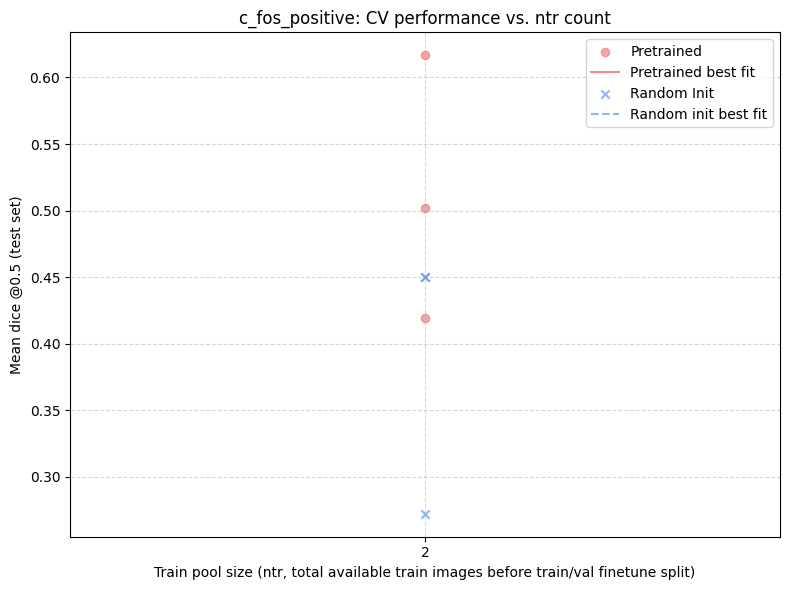

[INFO] cell_nucleus: Scanned 66 tags, found 66 CSV files, collected 66 points.
[INFO] cell_nucleus: Scanned 66 tags, found 66 CSV files, collected 66 points.


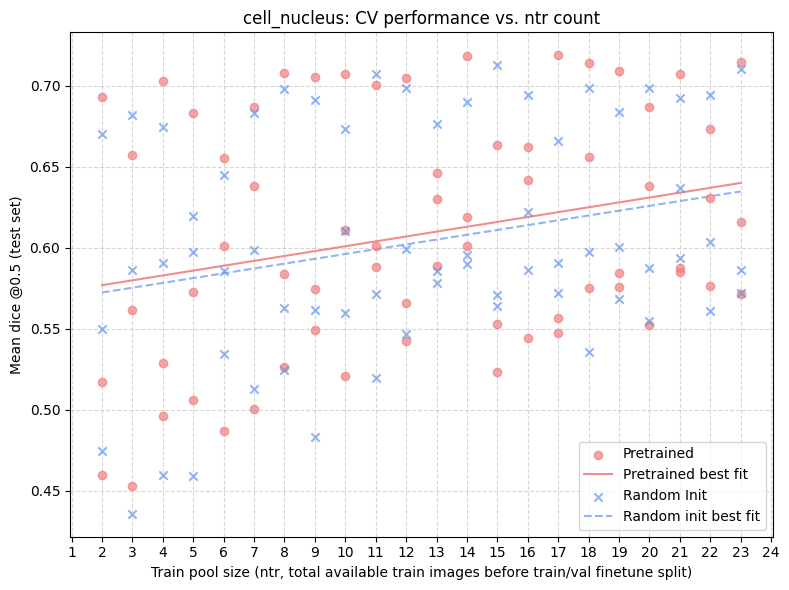

[INFO] vessels: Scanned 56 tags, found 56 CSV files, collected 56 points.
[INFO] vessels: Scanned 57 tags, found 57 CSV files, collected 57 points.


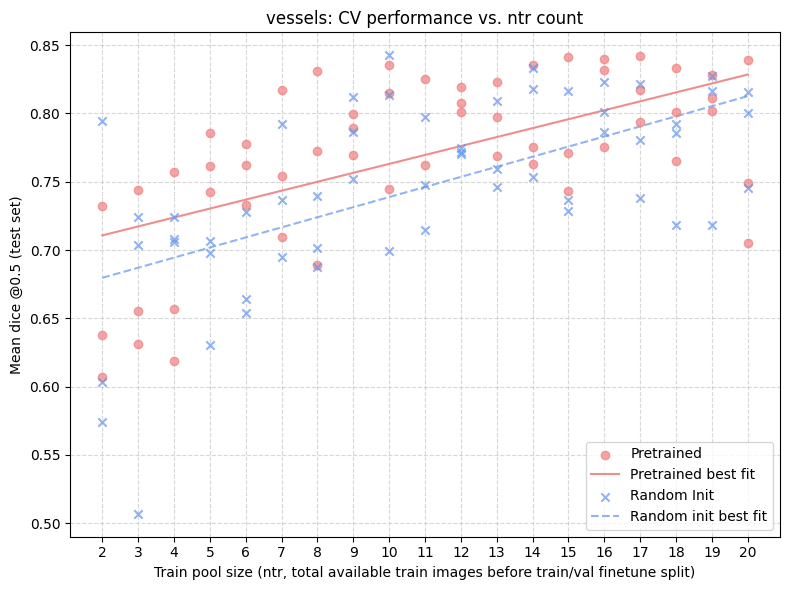

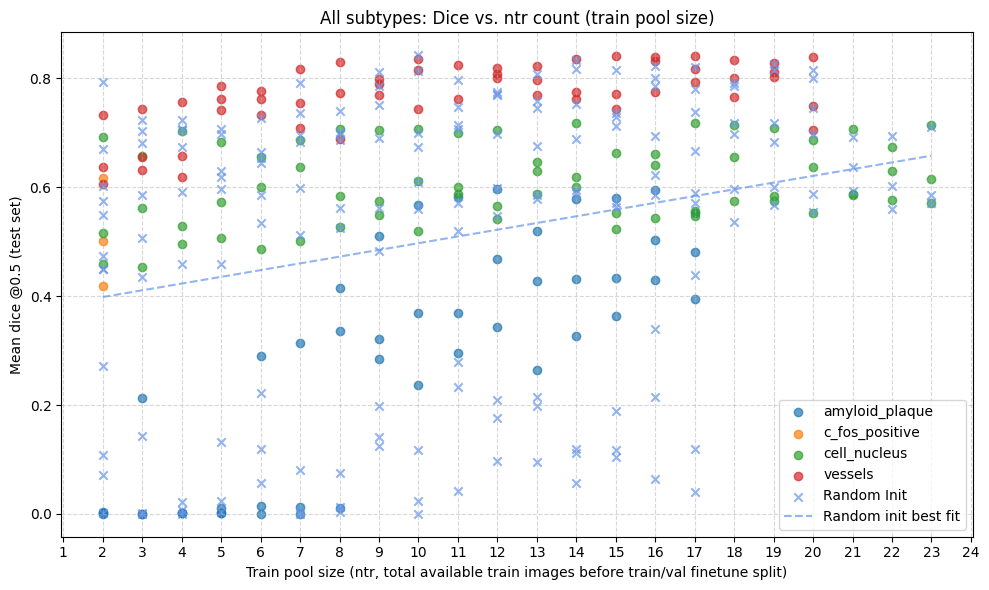

[INFO] Artifacts: {'subtypes': ['amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'vessels'], 'plots': {'amyloid_plaque': None, 'c_fos_positive': None, 'cell_nucleus': None, 'vessels': None}, 'combined_plot': None, 'summary_csv': None, 'summary_rows': [{'subtype': 'amyloid_plaque', 'train_count': '10', 'fold_id': 0, 'mean_dice_050': '0.236839', 'metrics_csv': '/ministorage/adina/selma_segmentation_preds_autumn_sweep_27/preds/amyloid_plaque/cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_seed100/preds/metrics_test_cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_seed100.csv', 'tag': 'cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_seed100'}, {'subtype': 'amyloid_plaque', 'train_count': '11', 'fold_id': 0, 'mean_dice_050': '0.296267', 'metrics_csv': '/ministorage/adina/selma_segmentation_preds_autumn_sweep_27/preds/amyloid_plaque/cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_seed100/preds/metrics_test_cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_seed100.csv', 'tag': 'cvfold0_ntr11_nev2_fttr9

In [12]:
# main entry
if __name__ == '__main__':
    cfg = PlotConfig(
        ROOT='/ministorage/adina/selma_segmentation_preds_autumn_sweep_27/preds',
        SUBTYPES=['ALL'],
        EXCLUDE_SUBTYPES=['cv_folds'],
        OUTPUT_DIR=None,
        ASCENDING=True,
        SAVE_SUMMARY_CSV=False,
        PLOT_COMBINED=True,
        POINT_COLOR='lightcoral',
        LINE_COLOR='lightcoral',

        # enable random init overlay
        INCLUDE_RAND=True,
        RAND_ROOT='/ministorage/adina/selma_segmentation_preds_rand/preds',
        RAND_POINT_COLOR='cornflowerblue',
        RAND_MARKER='x',
        RAND_POINT_ALPHA=0.7,
        RAND_LABEL='Random Init',

        # best fit line for random init
        RAND_FIT_LINE=True,
        RAND_LINESTYLE='--',
        RAND_LINE_ALPHA=0.7,
        RAND_LINE_COLOR=None, # defaults to RAND_POINT_COLOR if None
        RAND_LINE_LABEL='Random init best fit'
    )
    artifacts = main(cfg)
    print(f'[INFO] Artifacts: {artifacts}')


In [13]:
## UP TO HERE

## Combined plots

In [14]:
# data class to compare multiple 

In [15]:
# =========================
# Compare two preds roots + rand
# =========================
from dataclasses import dataclass
from typing import Dict, List, Tuple

@dataclass
class CompareConfig:
    ROOTS: List[Tuple[str, str]]  # list of (label, path_to_preds)
    RAND_ROOT: str = '/ministorage/adina/selma_segmentation_preds_rand/preds'
    SUBTYPES: List[str] = None          # ['ALL'] or explicit list
    EXCLUDE_SUBTYPES: List[str] = None  # e.g., ['cv_folds']
    OUTPUT_DIR: str = None              # dir to save plots; if None, show only
    ASCENDING: bool = True              # x-axis low->high if True
    SAVE_SUMMARY_CSV: bool = False      # optional CSV of all points
    PLOT_COMBINED: bool = True          # also make an all-subtypes overlay

    # style
    SERIES_STYLES: Dict[str, dict] = None  # label -> dict(color, marker, alpha)
    RAND_STYLE: dict = None                # dict(color, marker, alpha, line)

    # best-fit lines
    FIT_LINES: bool = True
    RAND_FIT_LINE: bool = True

    def __post_init__(self):
        if self.SUBTYPES is None:
            self.SUBTYPES = ['ALL']
        if self.EXCLUDE_SUBTYPES is None:
            self.EXCLUDE_SUBTYPES = ['cv_folds']
        if self.SERIES_STYLES is None:
            # sensible defaults for your two roots
            self.SERIES_STYLES = {
                # you can override by using the same key as the label in ROOTS
                'autumn_sweep_27': dict(color='cornflowerblue', marker='o', alpha=0.8, line_color='cornflowerblue'),
                'expert_sweep_31': dict(color='lightcoral',     marker='s', alpha=0.8, line_color='lightcoral'),
            }
        if self.RAND_STYLE is None:
            self.RAND_STYLE = dict(color='dimgray', marker='x', alpha=0.7, line_color='dimgray', linestyle='--', line_alpha=0.8)


def _collect_points_for_roots(subtypes: List[str], roots: List[Tuple[str, Path]]) -> Dict[str, Dict[str, List[CVPoint]]]:
    """
    Returns: series_points[label][subtype] -> List[CVPoint]
    """
    series_points: Dict[str, Dict[str, List[CVPoint]]] = {}
    for label, root in roots:
        subtype_map: Dict[str, List[CVPoint]] = {}
        for st in subtypes:
            subtype_map[st] = collect_subtype_points(st, root)
        series_points[label] = subtype_map
    return series_points


def _fit_line(xs: List[float], ys: List[float]):
    if len(xs) < 2:
        return None
    x_min, x_max = min(xs), max(xs)
    xfit = np.linspace(x_min, x_max, 100)
    coeffs = np.polyfit(xs, ys, deg=1)
    yfit = np.polyval(coeffs, xfit)
    return xfit, yfit


def plot_subtype_compare(subtype: str,
                         series_points: Dict[str, List[CVPoint]],
                         rand_points: List[CVPoint] = None,
                         styles: Dict[str, dict] = None,
                         rand_style: dict = None,
                         ascending: bool = True,
                         outdir: Path = None,
                         fit_lines: bool = True,
                         rand_fit_line: bool = True):
    """
    Overlay scatter + optional best-fit lines for:
      - each pretrained series in series_points
      - optional random baseline
    """
    # nothing to plot?
    if not any(series_points.values()) and not rand_points:
        print(f'[WARN] No points to plot for {subtype}. Skipping.')
        return None

    plt.figure(figsize=(9, 6))
    all_xs_for_ticks = []

    # plot pretrained series
    for label, pts in series_points.items():
        if not pts:
            continue
        sty = (styles or {}).get(label, {})
        color = sty.get('color', None)
        marker = sty.get('marker', 'o')
        alpha  = sty.get('alpha', 0.8)
        line_color = sty.get('line_color', color)

        pts_sorted = sorted(pts, key=lambda r: r.train_count, reverse=not ascending)
        xs = [p.train_count for p in pts_sorted]
        ys = [p.mean_dice for p in pts_sorted]
        all_xs_for_ticks.extend(xs)

        plt.scatter(xs, ys, label=label, marker=marker, color=color, alpha=alpha, zorder=3)

        if fit_lines and len(xs) >= 2:
            fit = _fit_line(xs, ys)
            if fit is not None:
                xfit, yfit = fit
                plt.plot(xfit, yfit, '-', color=line_color, alpha=0.9, label=f'{label} best fit', zorder=2)

    # overlay random
    if rand_points:
        rs = sorted(rand_points, key=lambda r: r.train_count, reverse=not ascending)
        rxs = [r.train_count for r in rs]
        rys = [r.mean_dice for r in rs]
        all_xs_for_ticks.extend(rxs)

        rcolor = (rand_style or {}).get('color', 'dimgray')
        rmarker = (rand_style or {}).get('marker', 'x')
        ralpha = (rand_style or {}).get('alpha', 0.7)
        rline_color = (rand_style or {}).get('line_color', rcolor)
        rlinestyle = (rand_style or {}).get('linestyle', '--')
        rline_alpha = (rand_style or {}).get('line_alpha', 0.8)

        plt.scatter(rxs, rys, label='Random init', marker=rmarker, color=rcolor, alpha=ralpha, zorder=3)

        if rand_fit_line and len(rxs) >= 2:
            fit = _fit_line(rxs, rys)
            if fit is not None:
                xfit, yfit = fit
                plt.plot(xfit, yfit, rlinestyle, color=rline_color, alpha=rline_alpha, label='Random init best fit', zorder=2)

    # axis formatting
    ax = plt.gca()
    if all_xs_for_ticks:
        ax.set_xticks(range(min(all_xs_for_ticks), max(all_xs_for_ticks) + 1, 1))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    if not ascending:
        ax.invert_xaxis()

    plt.xlabel('Train pool size (ntr, total available train images before train/val finetune split)')
    plt.ylabel('Mean dice @0.5 (test set)')
    plt.title(f'{subtype}: Pretrained (2 sets) vs Random')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='best')
    plt.tight_layout()

    if outdir is not None:
        outdir.mkdir(parents=True, exist_ok=True)
        outpath = outdir / f'{subtype}_compare_two_roots_vs_rand.png'
        plt.savefig(outpath)
        plt.close()
        return outpath

    plt.show()
    return None


def plot_combined_compare(series_points_by_label: Dict[str, Dict[str, List[CVPoint]]],
                          rand_points_by_subtype: Dict[str, List[CVPoint]] = None,
                          styles: Dict[str, dict] = None,
                          rand_style: dict = None,
                          ascending: bool = True,
                          outdir: Path = None):
    """
    Combined overlay across all subtypes:
      - scatter all points from each series (one color/marker per series)
      - optional random overlay
      - optional best-fit lines per series and for random
    """
    plt.figure(figsize=(10, 6))
    all_xs = []

    # flatten per series across subtypes
    for label, subtype_map in series_points_by_label.items():
        pts_all = [p for pts in subtype_map.values() for p in pts]
        if not pts_all:
            continue
        sty = (styles or {}).get(label, {})
        color = sty.get('color', None)
        marker = sty.get('marker', 'o')
        alpha  = sty.get('alpha', 0.8)
        line_color = sty.get('line_color', color)

        pts_sorted = sorted(pts_all, key=lambda r: r.train_count, reverse=not ascending)
        xs = [p.train_count for p in pts_sorted]
        ys = [p.mean_dice for p in pts_sorted]
        all_xs.extend(xs)

        plt.scatter(xs, ys, marker=marker, color=color, alpha=alpha, label=label)

        fit = _fit_line(xs, ys)
        if fit is not None:
            xfit, yfit = fit
            plt.plot(xfit, yfit, '-', color=line_color, alpha=0.9, label=f'{label} best fit')

    # random overlay combined
    if rand_points_by_subtype:
        r_all = [p for pts in rand_points_by_subtype.values() for p in pts]
        if r_all:
            r_all_sorted = sorted(r_all, key=lambda r: r.train_count, reverse=not ascending)
            rxs = [r.train_count for r in r_all_sorted]
            rys = [r.mean_dice for r in r_all_sorted]
            all_xs.extend(rxs)

            rcolor = (rand_style or {}).get('color', 'dimgray')
            rmarker = (rand_style or {}).get('marker', 'x')
            ralpha = (rand_style or {}).get('alpha', 0.7)
            rline_color = (rand_style or {}).get('line_color', rcolor)
            rlinestyle = (rand_style or {}).get('linestyle', '--')
            rline_alpha = (rand_style or {}).get('line_alpha', 0.8)

            plt.scatter(rxs, rys, marker=rmarker, color=rcolor, alpha=ralpha, label='Random init')

            fit = _fit_line(rxs, rys)
            if fit is not None:
                xfit, yfit = fit
                plt.plot(xfit, yfit, rlinestyle, color=rline_color, alpha=rline_alpha, label='Random init best fit')

    ax = plt.gca()
    if all_xs:
        ax.set_xticks(range(min(all_xs), max(all_xs) + 1, 1))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    if not ascending:
        ax.invert_xaxis()

    plt.xlabel('Finetune train size (fttr)')
    plt.ylabel('Mean dice @0.5 (test set)')
    plt.title('All subtypes: Two pretrained sets vs Random')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='best')
    plt.tight_layout()

    if outdir is not None:
        outdir.mkdir(parents=True, exist_ok=True)
        outpath = outdir / 'ALL_subtypes_compare_two_roots_vs_rand.png'
        plt.savefig(outpath)
        plt.close()
        return outpath

    plt.show()
    return None


def compare_two_pretrained_vs_rand(cfg: CompareConfig):
    """
    High-level entry: builds per-subtype plots and an optional combined plot.
    Returns a dict with artifacts.
    """
    roots = [(label, Path(path)) for (label, path) in cfg.ROOTS]
    for label, p in roots:
        if not p.exists():
            print(f'[WARN] Root does not exist for "{label}": {p}')

    # determine subtypes once (from first existing root)
    first_existing = next((p for _, p in roots if p.exists()), None)
    if first_existing is None:
        print('[ERROR] No existing ROOTS found.')
        return {}

    subtypes = find_subtypes(first_existing, cfg.SUBTYPES, cfg.EXCLUDE_SUBTYPES)
    print(f'[INFO] Compare subtypes: {subtypes}')

    outdir = Path(cfg.OUTPUT_DIR) if cfg.OUTPUT_DIR else None

    # collect series points
    series_points_by_label = _collect_points_for_roots(subtypes, roots)

    # random per subtype
    rand_points_by_subtype = {}
    rand_root = Path(cfg.RAND_ROOT) if cfg.RAND_ROOT else None
    if rand_root and rand_root.exists():
        for st in subtypes:
            rand_points_by_subtype[st] = collect_subtype_points(st, rand_root)
    else:
        print(f'[WARN] RAND_ROOT {rand_root} not found; skipping random baseline.')

    # per-subtype overlay plots
    per_subtype_paths = {}
    for st in subtypes:
        series_points_flat = {label: series_points_by_label[label].get(st, []) for label, _ in roots}
        rand_pts = rand_points_by_subtype.get(st, [])
        p = plot_subtype_compare(
            subtype=st,
            series_points=series_points_flat,
            rand_points=rand_pts,
            styles=cfg.SERIES_STYLES,
            rand_style=cfg.RAND_STYLE,
            ascending=cfg.ASCENDING,
            outdir=outdir,
            fit_lines=cfg.FIT_LINES,
            rand_fit_line=cfg.RAND_FIT_LINE
        )
        per_subtype_paths[st] = p

    # combined overlay
    combined_path = None
    if cfg.PLOT_COMBINED:
        combined_path = plot_combined_compare(
            series_points_by_label=series_points_by_label,
            rand_points_by_subtype=rand_points_by_subtype if rand_points_by_subtype else None,
            styles=cfg.SERIES_STYLES,
            rand_style=cfg.RAND_STYLE,
            ascending=cfg.ASCENDING,
            outdir=outdir
        )

    return {
        'subtypes': subtypes,
        'per_subtype_plots': per_subtype_paths,
        'combined_plot': combined_path
    }


[INFO] Compare subtypes: ['amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'vessels']
[INFO] amyloid_plaque: Scanned 48 tags, found 48 CSV files, collected 48 points.
[INFO] c_fos_positive: Scanned 3 tags, found 3 CSV files, collected 3 points.
[INFO] cell_nucleus: Scanned 66 tags, found 66 CSV files, collected 66 points.
[INFO] vessels: Scanned 56 tags, found 56 CSV files, collected 56 points.
[INFO] amyloid_plaque: Scanned 48 tags, found 48 CSV files, collected 48 points.
[INFO] c_fos_positive: Scanned 3 tags, found 3 CSV files, collected 3 points.
[INFO] cell_nucleus: Scanned 66 tags, found 66 CSV files, collected 66 points.
[INFO] vessels: Scanned 57 tags, found 57 CSV files, collected 57 points.
[INFO] amyloid_plaque: Scanned 48 tags, found 48 CSV files, collected 48 points.
[INFO] c_fos_positive: Scanned 3 tags, found 3 CSV files, collected 3 points.
[INFO] cell_nucleus: Scanned 66 tags, found 66 CSV files, collected 66 points.
[INFO] vessels: Scanned 57 tags, found 57 CSV fil

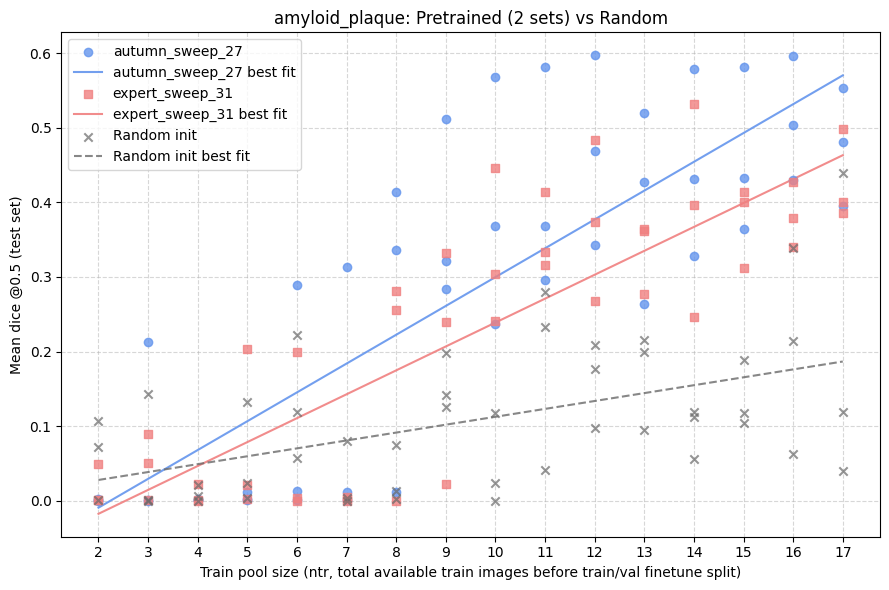

/tmp/ipykernel_2108169/2249253110.py:60: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(xs, ys, deg=1)
/tmp/ipykernel_2108169/2249253110.py:60: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(xs, ys, deg=1)
/tmp/ipykernel_2108169/2249253110.py:60: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(xs, ys, deg=1)


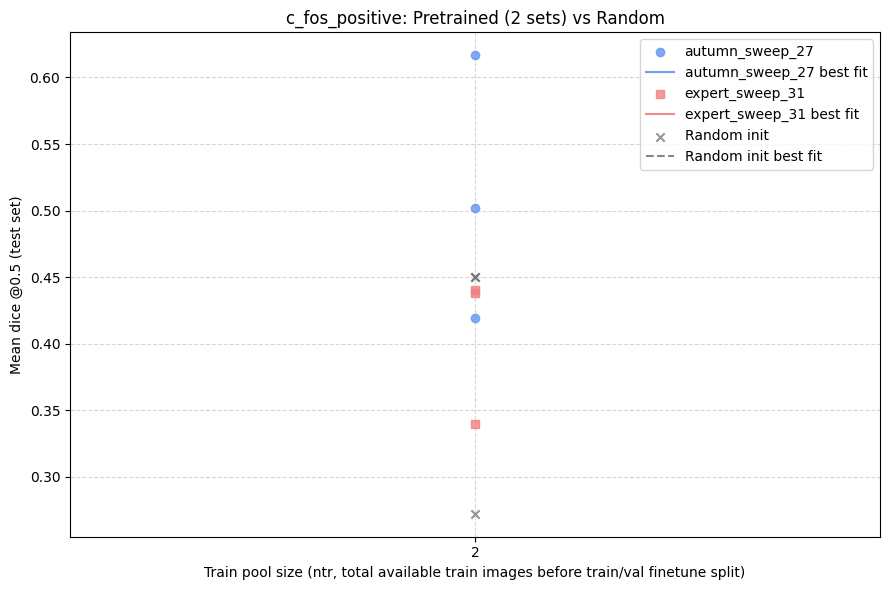

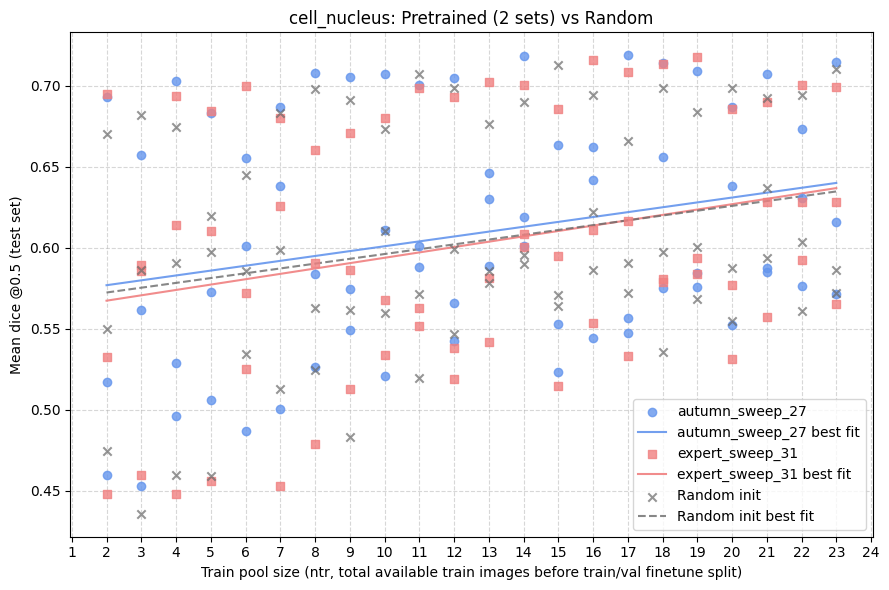

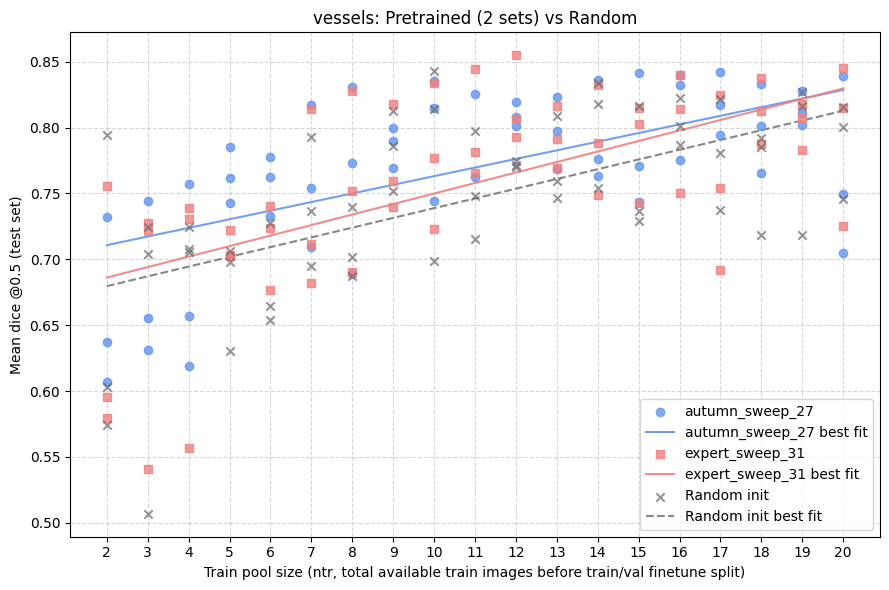

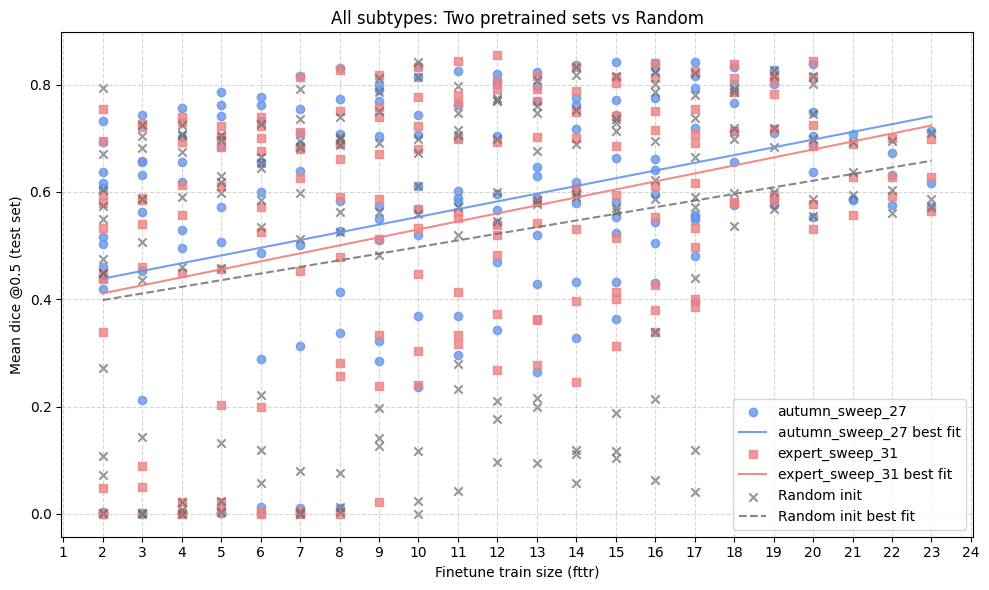

{'subtypes': ['amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'vessels'],
 'per_subtype_plots': {'amyloid_plaque': None,
  'c_fos_positive': None,
  'cell_nucleus': None,
  'vessels': None},
 'combined_plot': None}

In [16]:
cmp_cfg = CompareConfig(
    ROOTS=[
        ('autumn_sweep_27', '/ministorage/adina/selma_segmentation_preds_autumn_sweep_27/preds'),
        ('expert_sweep_31', '/ministorage/adina/selma_segmentation_preds_expert_sweep_31/preds'),
    ],
    RAND_ROOT='/ministorage/adina/selma_segmentation_preds_rand/preds',
    SUBTYPES=['ALL'],                 # or e.g., ['vessels'] to focus
    EXCLUDE_SUBTYPES=['cv_folds'],
    OUTPUT_DIR=None,                  # or a path to save images
    ASCENDING=True,
    PLOT_COMBINED=True,

    # Optional: override colors/markers per series label
    SERIES_STYLES={
        'autumn_sweep_27': dict(color='cornflowerblue', marker='o', alpha=0.8, line_color='cornflowerblue'),
        'expert_sweep_31': dict(color='lightcoral',     marker='s', alpha=0.8, line_color='lightcoral'),
    },
    RAND_STYLE=dict(color='dimgray', marker='x', alpha=0.7, line_color='dimgray', linestyle='--', line_alpha=0.8),

    FIT_LINES=True,
    RAND_FIT_LINE=True,
)
compare_artifacts = compare_two_pretrained_vs_rand(cmp_cfg)
compare_artifacts

